# Recurrnet Neural Network
* https://www.youtube.com/watch?v=WEV61GmmPrk&list=PLqnslRFeH2UrcDBWF5mfPGpqQDSta6VK4&index=19
* https://github.com/patrickloeber/pytorch-examples
* pytorchにRNNの関数あるが、ここではスクラッチから作成する

In [1]:
from PIL import Image

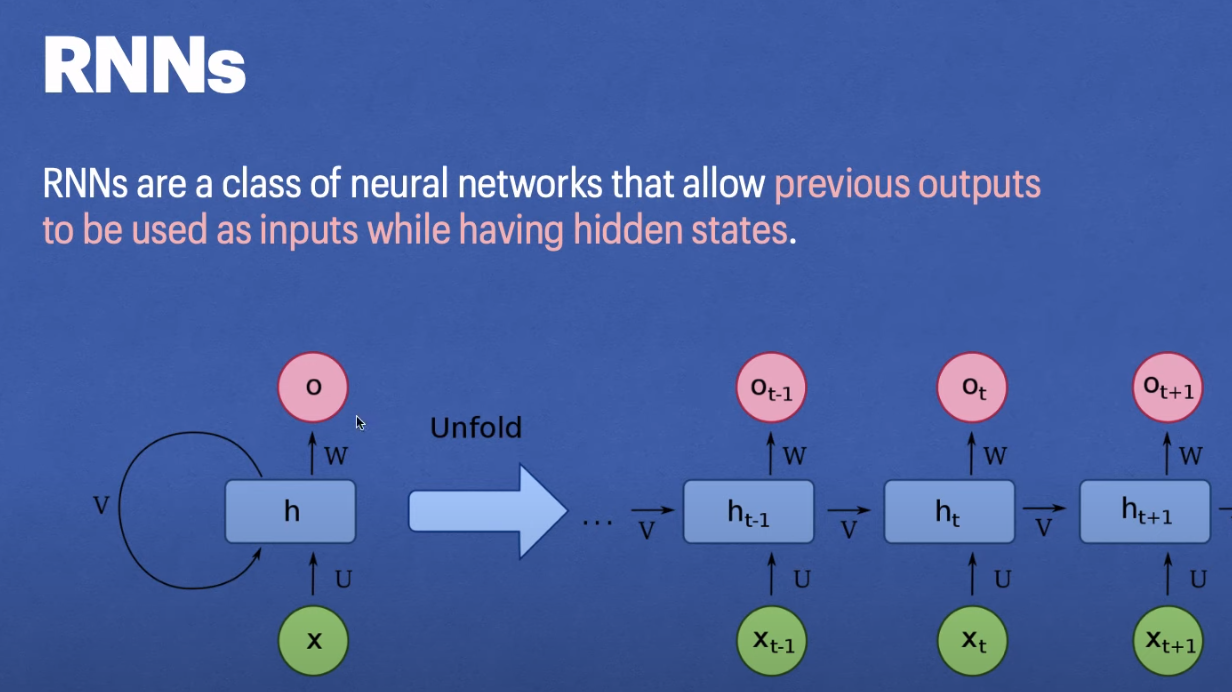

In [2]:
im = Image.open('/content/drive/MyDrive/study_DeepLearning/data/rnn.png')
im

In [16]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
# from utils import ALL_LETTERS, N_LETTERS
# from utils import l

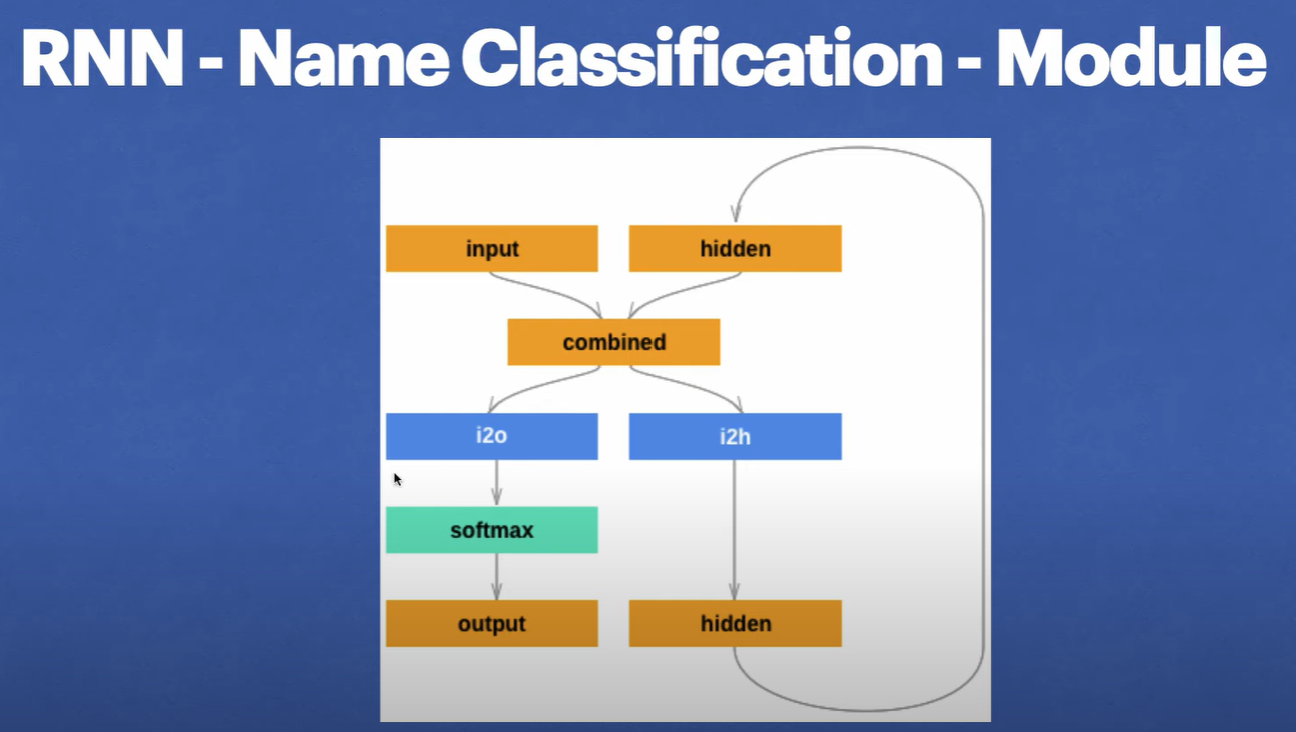

In [17]:
im = Image.open('/content/drive/MyDrive/study_DeepLearning/data/rnn_name_classification.png')
im

* i2o = input to output
* i2h = input to hidden layer

In [18]:
class RNN(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(RNN, self).__init__()

    self.hidden_size = hidden_size
    self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
    self.i2o = nn.Linear(input_size + hidden_size, output_size)
    self.softmax = nn.LogSoftmax(dim=1)

  def forward(self, input_tensor, hidden_tensor):
    combined = torch.cat((input_tensor, hidden_tensor), 1)

    hidden = self.i2h(combined)
    output = self.i2o(combined)
    output = self.softmax(output)
    return output, hidden

  def init_hidden(self):
    return torch.zeros(1, self.hidden_size)



In [19]:
# load data
category_lines, all_categories = load_data()
n_categories = len(all_categories)
print(n_categories)

18


In [21]:
n_hidden = 128
rnn = RNN(N_LETTERS, n_hidden, n_categories)

# one step
input_tensor = letter_to_tensor('A')
hidden_tensor = rnn.init_hidden()

output, next_hidden = rnn(input_tensor, hidden_tensor)
print(output.size())
print(next_hidden.size())

torch.Size([1, 18])
torch.Size([1, 128])


In [22]:
output

tensor([[-2.8054, -2.8953, -2.9124, -2.9749, -2.8603, -2.9396, -2.9378, -2.9068,
         -2.9364, -3.0022, -2.9614, -2.8422, -2.8637, -2.8541, -2.9245, -2.8180,
         -2.7899, -2.8341]], grad_fn=<LogSoftmaxBackward0>)

In [24]:
def category_from_output(output):
  category_idx = torch.argmax(output).item()
  return all_categories[category_idx]

In [27]:
# whole sequence/name
input_tensor = line_to_tensor('Albert')
hidden_tensor = rnn.init_hidden()

# 1文字だけから判断
output, next_hidden = rnn(input_tensor[0], hidden_tensor)
print(output.size())
print(next_hidden.size())

print(category_from_output(output))

torch.Size([1, 18])
torch.Size([1, 128])
Chinese


In [30]:
# 学習用関数

criterion = nn.NLLLoss()
learning_rate = 0.005
optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate)

def train(line_tensor, category_tensor):
  hidden = rnn.init_hidden()
  # 単語を1文字ごとにループして学習する
  for i in range(line_tensor.size()[0]):
    output, hidden = rnn(line_tensor[i], hidden)

  loss = criterion(output, category_tensor)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  return output, loss.item()

999 0.9990000000000001 2.9708 Ciardha / Japanese WRONG (Irish)
1999 1.999 2.7253 Simpson / English WRONG (Scottish)
2999 2.999 3.0210 Salazar / German WRONG (Portuguese)
3999 3.9989999999999997 2.3493 Pei / Chinese CORRENT
4999 4.999 2.9641 Muchalon / Russian WRONG (Czech)
5999 5.9990000000000006 3.5879 Sone / Chinese WRONG (Japanese)
6999 6.999 1.4630 Kalinov / Russian CORRENT
7999 7.9990000000000006 2.1099 Romero / Portuguese WRONG (Italian)
8999 8.999 2.0583 Greenberg / Dutch WRONG (German)
9999 9.998999999999999 1.3159 Kurata / Japanese CORRENT
10999 10.999 1.9378 Giang / Vietnamese CORRENT
11999 11.999 1.4691 Andrysiak / Polish CORRENT
12999 12.998999999999999 0.6106 Sardelis / Greek CORRENT
13999 13.999 1.4960 Rijnders / Dutch CORRENT
14999 14.999 3.2116 O'Connor / Scottish WRONG (Irish)
15999 15.998999999999999 1.0021 Gui / Chinese CORRENT
16999 16.999 1.3221 Han / Chinese WRONG (Vietnamese)
17999 17.999000000000002 1.5054 Lucassen / Dutch CORRENT
18999 18.999 2.7463 Seif / Kore

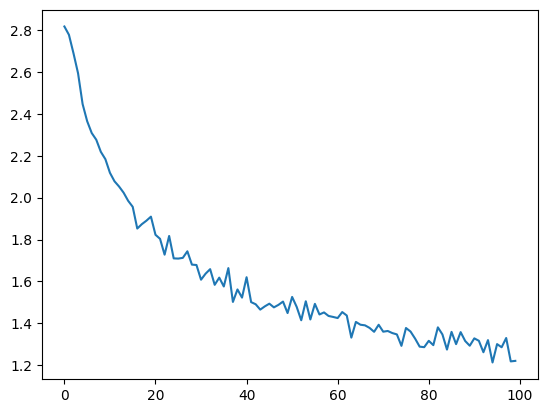

In [32]:
current_loss = 0
all_losses = []
plot_steps, print_steps = 1000, 5000
n_iters = 100000
for i in range(n_iters):
  category, line, category_tensor, line_tensor = random_training_example(category_lines, all_categories)

  output, loss = train(line_tensor, category_tensor)
  current_loss += loss

  if (i+1) % plot_steps == 0:
    all_losses.append(current_loss / plot_steps)
    current_loss = 0

  if (i+1) % plot_steps == 0:
    guess = category_from_output(output)
    correct = "CORRENT" if guess == category else f"WRONG ({category})"
    print(f"{i} {i/n_iters*100} {loss:.4f} {line} / {guess} {correct}")

plt.figure()
plt.plot(all_losses)
plt.show()

In [35]:
# predict用関数
def pridict(input_line):
  print(f"\n> {input_line}")
  with torch.no_grad():
    line_tensor = line_to_tensor(input_line)

    hidden = rnn.init_hidden()

    for i in range(line_tensor.size()[0]):
      output, hidden = rnn(line_tensor[i], hidden)

    guess = category_from_output(output)
    print(guess)

In [40]:
# Ichinose
pridict('Ichinose')


> Ichinose
Japanese


In [39]:
# Sugimoto
pridict('Sugimoto')


> Sugimoto
Japanese


# * utils.py

In [11]:
# data: https://download.pytorch.org/tutorial/data.zip
import io
import os
import unicodedata
import string
import glob

import torch
import random

# alphabet small + capital letters + " .,;'"
ALL_LETTERS = string.ascii_letters + " .,;'"
N_LETTERS = len(ALL_LETTERS)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in ALL_LETTERS
    )

def load_data():
    # Build the category_lines dictionary, a list of names per language
    category_lines = {}
    all_categories = []

    def find_files(path):
        return glob.glob(path)

    # Read a file and split into lines
    def read_lines(filename):
        lines = io.open(filename, encoding='utf-8').read().strip().split('\n')
        return [unicode_to_ascii(line) for line in lines]

    for filename in find_files('/content/drive/MyDrive/study_DeepLearning/data/data/data/names/*.txt'):
        category = os.path.splitext(os.path.basename(filename))[0]
        all_categories.append(category)

        lines = read_lines(filename)
        category_lines[category] = lines

    return category_lines, all_categories



"""
To represent a single letter, we use a “one-hot vector” of
size <1 x n_letters>. A one-hot vector is filled with 0s
except for a 1 at index of the current letter, e.g. "b" = <0 1 0 0 0 ...>.

To make a word we join a bunch of those into a
2D matrix <line_length x 1 x n_letters>.

That extra 1 dimension is because PyTorch assumes
everything is in batches - we’re just using a batch size of 1 here.
"""

# Find letter index from all_letters, e.g. "a" = 0
def letter_to_index(letter):
    return ALL_LETTERS.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letter_to_tensor(letter):
    tensor = torch.zeros(1, N_LETTERS)
    tensor[0][letter_to_index(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def line_to_tensor(line):
    tensor = torch.zeros(len(line), 1, N_LETTERS)
    for i, letter in enumerate(line):
        tensor[i][0][letter_to_index(letter)] = 1
    return tensor


def random_training_example(category_lines, all_categories):

    def random_choice(a):
        random_idx = random.randint(0, len(a) - 1)
        return a[random_idx]

    category = random_choice(all_categories)
    line = random_choice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = line_to_tensor(line)
    return category, line, category_tensor, line_tensor



# if __name__ == '__main__':
#     print(ALL_LETTERS)
#     print(unicode_to_ascii('Ślusàrski'))

#     category_lines, all_categories = load_data()
#     print(category_lines['Italian'][:5])

#     print(letter_to_tensor('J')) # [1, 57]
#     print(line_to_tensor('Jones').size()) # [5, 1, 57]

In [5]:
print(ALL_LETTERS)
print(unicode_to_ascii('Ślusàrski'))

abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'
Slusarski


In [8]:
def find_files(path):
  return glob.glob(path)
for filename in find_files('/content/drive/MyDrive/study_DeepLearning/data/data/data/names/*.txt'):
  category = os.path.splitext(os.path.basename(filename))[0]
  break

In [9]:
os.path.splitext(os.path.basename(filename))

('Spanish', '.txt')

In [10]:
category

'Spanish'

In [12]:
category_lines, all_categories = load_data()
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


In [14]:
type(category_lines)

dict

In [15]:
all_categories

['Spanish',
 'Vietnamese',
 'Scottish',
 'Polish',
 'Korean',
 'Japanese',
 'Portuguese',
 'Italian',
 'Irish',
 'French',
 'Greek',
 'Russian',
 'German',
 'Czech',
 'Arabic',
 'Dutch',
 'Chinese',
 'English']